In [3]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Top-1 PCA Acc: 1.0
Top-2 PCA Acc: 1.0


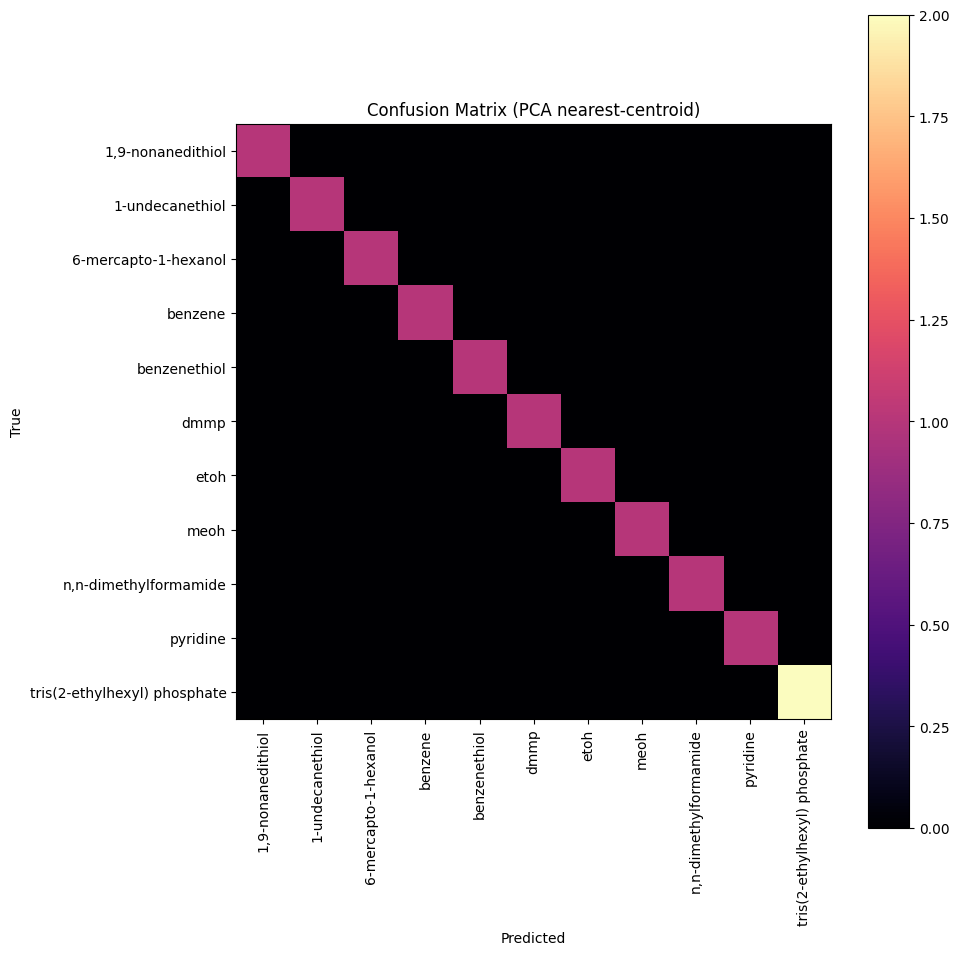

In [9]:
# 1. Load data
ref_df   = pd.read_csv('Jesse_Dataset/reference_subset_1.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_with_pca(query_df, ref_df,
                     crop_max=2500, lam=1e4, p=0.01, niter=10,
                     n_pca=10):
    # --- prepare matrices ---
    wavs      = pd.to_numeric(query_df.columns[:-1])
    keep_idxs = np.where(wavs < crop_max)[0]
    Q_raw     = query_df.iloc[:, keep_idxs].values
    R_raw     = ref_df  .iloc[:, keep_idxs].values
    labels    = ref_df['Label'].values
    classes   = np.unique(labels)
    
    # --- baseline & ℓ2-normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- PCA on reference spectra ---
    pca      = PCA(n_components=n_pca)
    R_pca    = pca.fit_transform(R)
    Q_pca    = pca.transform(Q)
    
    # --- compute class centroids in PCA space ---
    centroids = {
        chem: R_pca[labels==chem].mean(axis=0)
        for chem in classes
    }

    # --- classify by nearest‐centroid in PCA space ---
    rankings = []
    for qv in Q_pca:
        # compute distance to each centroid
        dists = {chem: np.linalg.norm(qv - centroids[chem])
                 for chem in classes}
        # sort by ascending distance → lowest = best match
        ranking = sorted(dists, key=dists.get)
        rankings.append(ranking)

    return rankings, Q_pca, R_pca, centroids

# ---- run & evaluate ----
rankings, Q_pca, R_pca, centroids = identify_with_pca(query_df, ref_df)

true  = query_df['Label'].values
pred1 = [r[0] for r in rankings]
pred2 = [r[1] for r in rankings]

print("Top-1 PCA Acc:", accuracy_score(true, pred1))
print("Top-2 PCA Acc:", np.mean([t in (p1,p2) for t,p1,p2 in zip(true,pred1,pred2)]))

# Confusion matrix
labels_unique = np.unique(true)
cm = confusion_matrix(true, pred1, labels=labels_unique)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='magma', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=90)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (PCA nearest‐centroid)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Top-1 PCA Acc: 1.0
Top-2 PCA Acc: 1.0


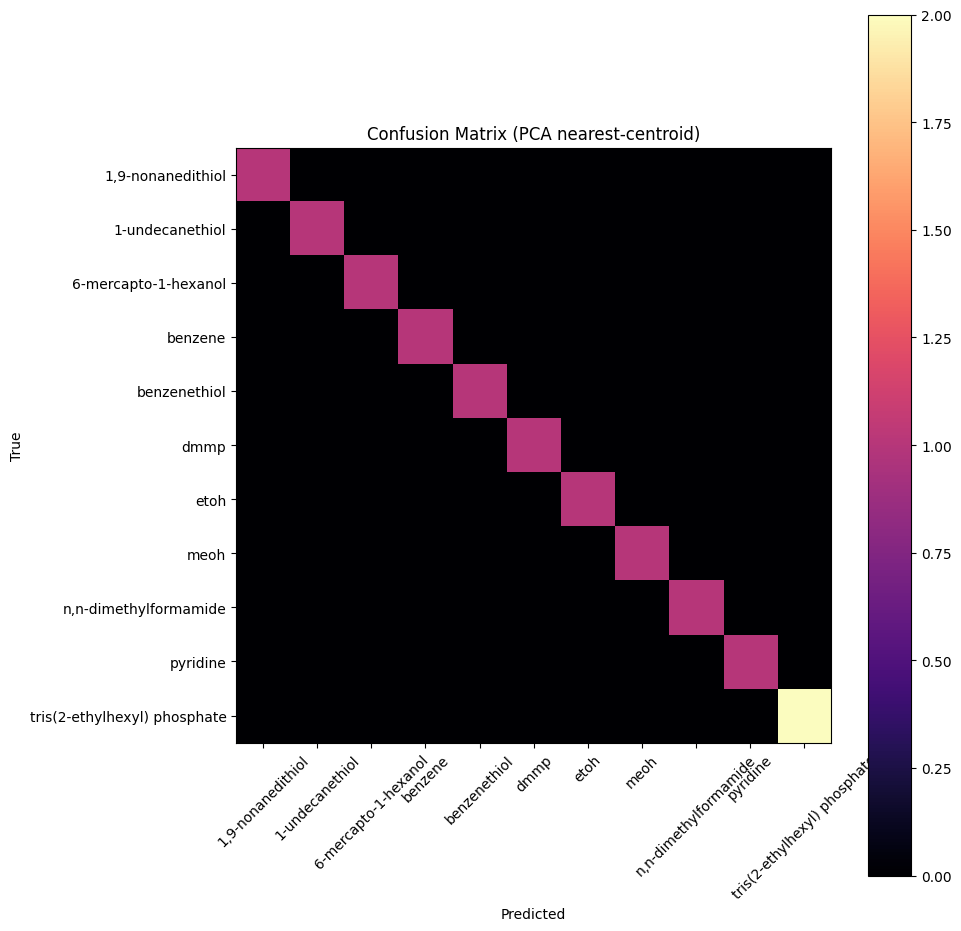

In [5]:
# 1. Load data
ref_df   = pd.read_csv('Jesse_Dataset/reference_subset_2.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_with_pca(query_df, ref_df,
                     crop_max=2500, lam=1e4, p=0.01, niter=10,
                     n_pca=10):
    # --- prepare matrices ---
    wavs      = pd.to_numeric(query_df.columns[:-1])
    keep_idxs = np.where(wavs < crop_max)[0]
    Q_raw     = query_df.iloc[:, keep_idxs].values
    R_raw     = ref_df  .iloc[:, keep_idxs].values
    labels    = ref_df['Label'].values
    classes   = np.unique(labels)
    
    # --- baseline & ℓ2-normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- PCA on reference spectra ---
    pca      = PCA(n_components=n_pca)
    R_pca    = pca.fit_transform(R)
    Q_pca    = pca.transform(Q)
    
    # --- compute class centroids in PCA space ---
    centroids = {
        chem: R_pca[labels==chem].mean(axis=0)
        for chem in classes
    }

    # --- classify by nearest‐centroid in PCA space ---
    rankings = []
    for qv in Q_pca:
        # compute distance to each centroid
        dists = {chem: np.linalg.norm(qv - centroids[chem])
                 for chem in classes}
        # sort by ascending distance → lowest = best match
        ranking = sorted(dists, key=dists.get)
        rankings.append(ranking)

    return rankings, Q_pca, R_pca, centroids

# ---- run & evaluate ----
rankings, Q_pca, R_pca, centroids = identify_with_pca(query_df, ref_df)

true  = query_df['Label'].values
pred1 = [r[0] for r in rankings]
pred2 = [r[1] for r in rankings]

print("Top-1 PCA Acc:", accuracy_score(true, pred1))
print("Top-2 PCA Acc:", np.mean([t in (p1,p2) for t,p1,p2 in zip(true,pred1,pred2)]))

# Confusion matrix
labels_unique = np.unique(true)
cm = confusion_matrix(true, pred1, labels=labels_unique)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='magma', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=45)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (PCA nearest‐centroid)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Top-1 PCA Acc: 1.0
Top-2 PCA Acc: 1.0


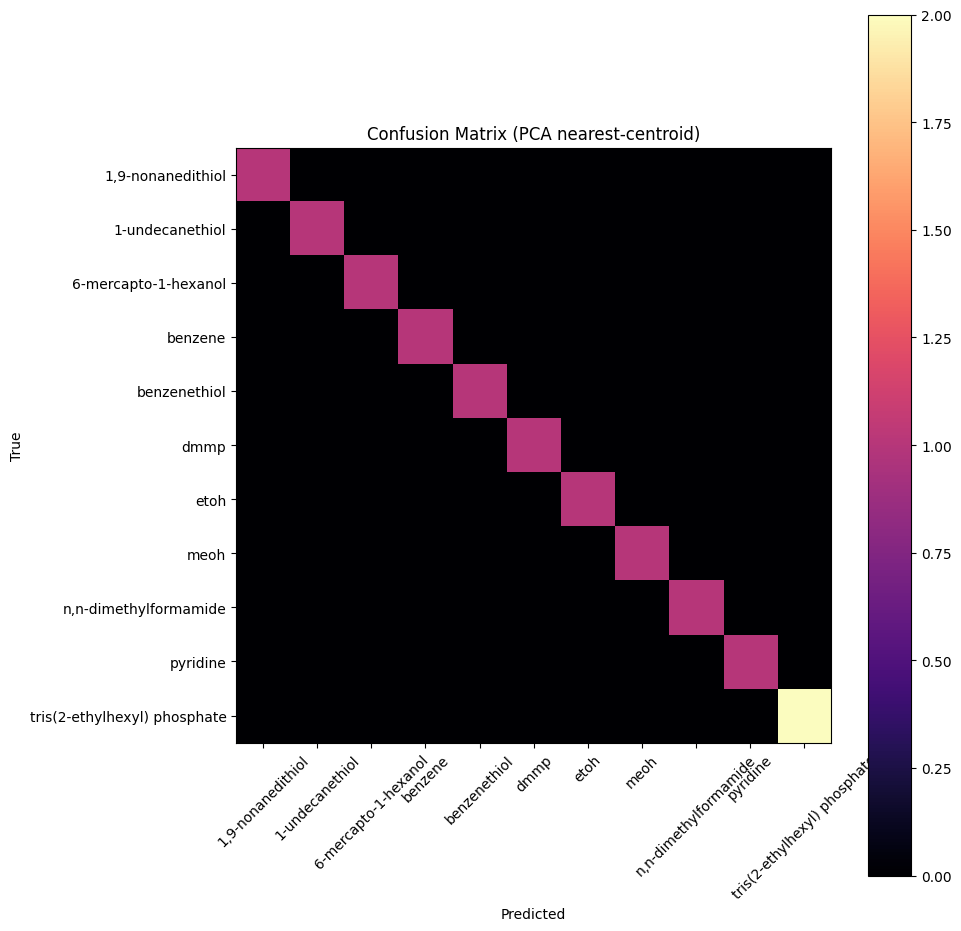

In [6]:
# 1. Load data
ref_df   = pd.read_csv('Jesse_Dataset/reference_subset_3.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_with_pca(query_df, ref_df,
                     crop_max=2500, lam=1e4, p=0.01, niter=10,
                     n_pca=10):
    # --- prepare matrices ---
    wavs      = pd.to_numeric(query_df.columns[:-1])
    keep_idxs = np.where(wavs < crop_max)[0]
    Q_raw     = query_df.iloc[:, keep_idxs].values
    R_raw     = ref_df  .iloc[:, keep_idxs].values
    labels    = ref_df['Label'].values
    classes   = np.unique(labels)
    
    # --- baseline & ℓ2-normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- PCA on reference spectra ---
    pca      = PCA(n_components=n_pca)
    R_pca    = pca.fit_transform(R)
    Q_pca    = pca.transform(Q)
    
    # --- compute class centroids in PCA space ---
    centroids = {
        chem: R_pca[labels==chem].mean(axis=0)
        for chem in classes
    }

    # --- classify by nearest‐centroid in PCA space ---
    rankings = []
    for qv in Q_pca:
        # compute distance to each centroid
        dists = {chem: np.linalg.norm(qv - centroids[chem])
                 for chem in classes}
        # sort by ascending distance → lowest = best match
        ranking = sorted(dists, key=dists.get)
        rankings.append(ranking)

    return rankings, Q_pca, R_pca, centroids

# ---- run & evaluate ----
rankings, Q_pca, R_pca, centroids = identify_with_pca(query_df, ref_df)

true  = query_df['Label'].values
pred1 = [r[0] for r in rankings]
pred2 = [r[1] for r in rankings]

print("Top-1 PCA Acc:", accuracy_score(true, pred1))
print("Top-2 PCA Acc:", np.mean([t in (p1,p2) for t,p1,p2 in zip(true,pred1,pred2)]))

# Confusion matrix
labels_unique = np.unique(true)
cm = confusion_matrix(true, pred1, labels=labels_unique)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='magma', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=45)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (PCA nearest‐centroid)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Top-1 PCA Acc: 1.0
Top-2 PCA Acc: 1.0


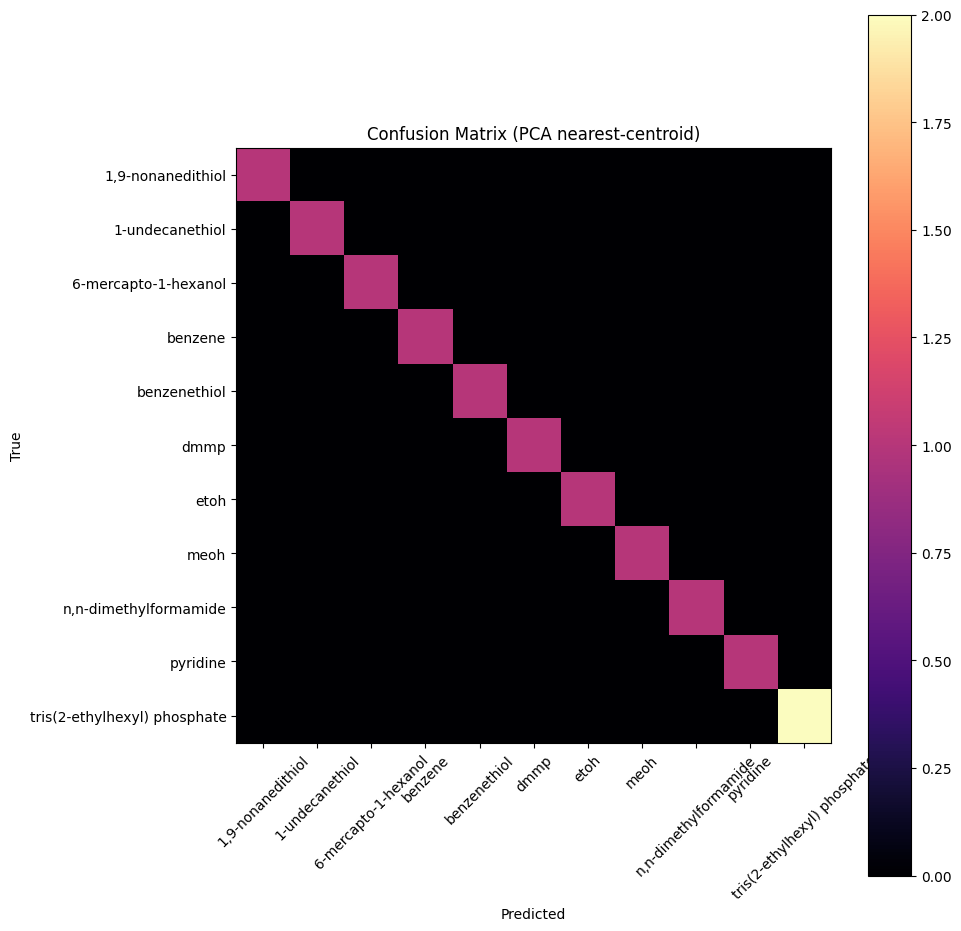

In [7]:
# 1. Load data
ref_df   = pd.read_csv('Jesse_Dataset/reference_subset_4.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_with_pca(query_df, ref_df,
                     crop_max=2500, lam=1e4, p=0.01, niter=10,
                     n_pca=10):
    # --- prepare matrices ---
    wavs      = pd.to_numeric(query_df.columns[:-1])
    keep_idxs = np.where(wavs < crop_max)[0]
    Q_raw     = query_df.iloc[:, keep_idxs].values
    R_raw     = ref_df  .iloc[:, keep_idxs].values
    labels    = ref_df['Label'].values
    classes   = np.unique(labels)
    
    # --- baseline & ℓ2-normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- PCA on reference spectra ---
    pca      = PCA(n_components=n_pca)
    R_pca    = pca.fit_transform(R)
    Q_pca    = pca.transform(Q)
    
    # --- compute class centroids in PCA space ---
    centroids = {
        chem: R_pca[labels==chem].mean(axis=0)
        for chem in classes
    }

    # --- classify by nearest‐centroid in PCA space ---
    rankings = []
    for qv in Q_pca:
        # compute distance to each centroid
        dists = {chem: np.linalg.norm(qv - centroids[chem])
                 for chem in classes}
        # sort by ascending distance → lowest = best match
        ranking = sorted(dists, key=dists.get)
        rankings.append(ranking)

    return rankings, Q_pca, R_pca, centroids

# ---- run & evaluate ----
rankings, Q_pca, R_pca, centroids = identify_with_pca(query_df, ref_df)

true  = query_df['Label'].values
pred1 = [r[0] for r in rankings]
pred2 = [r[1] for r in rankings]

print("Top-1 PCA Acc:", accuracy_score(true, pred1))
print("Top-2 PCA Acc:", np.mean([t in (p1,p2) for t,p1,p2 in zip(true,pred1,pred2)]))

# Confusion matrix
labels_unique = np.unique(true)
cm = confusion_matrix(true, pred1, labels=labels_unique)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='magma', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=45)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (PCA nearest‐centroid)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Top-1 PCA Acc: 1.0
Top-2 PCA Acc: 1.0


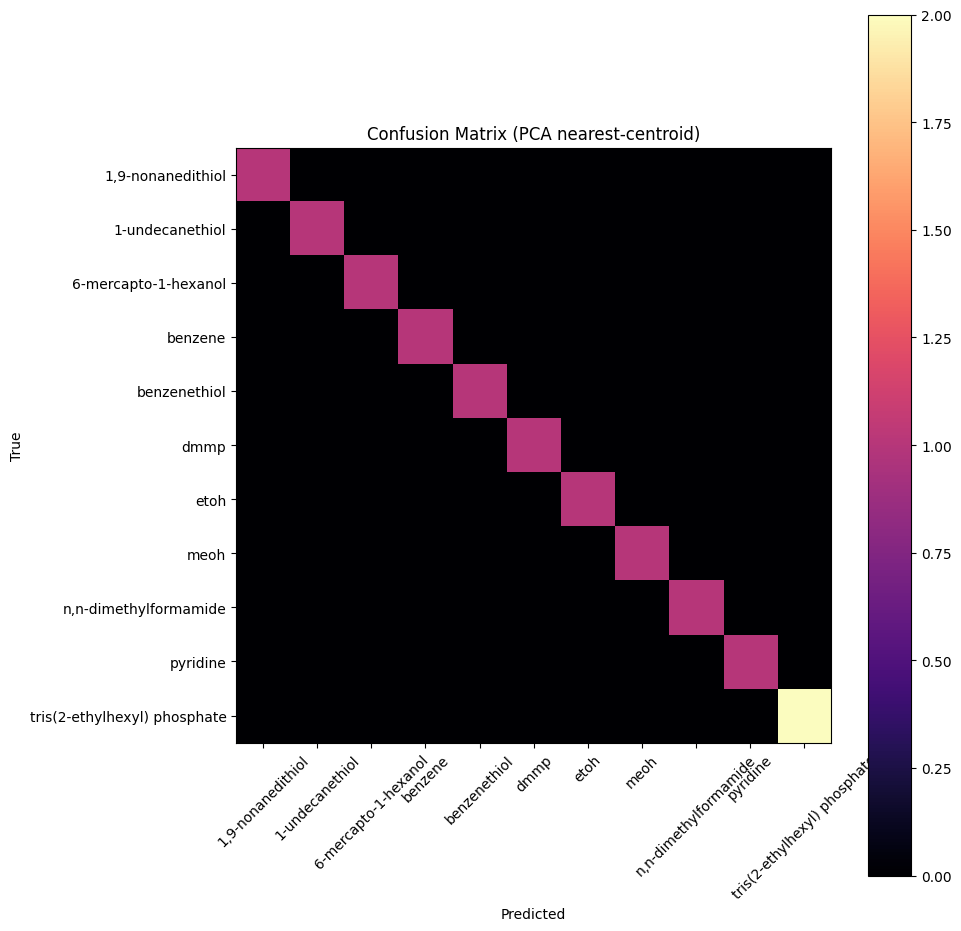

In [8]:
# 1. Load data
ref_df   = pd.read_csv('Jesse_Dataset/reference_subset_5.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_with_pca(query_df, ref_df,
                     crop_max=2500, lam=1e4, p=0.01, niter=10,
                     n_pca=10):
    # --- prepare matrices ---
    wavs      = pd.to_numeric(query_df.columns[:-1])
    keep_idxs = np.where(wavs < crop_max)[0]
    Q_raw     = query_df.iloc[:, keep_idxs].values
    R_raw     = ref_df  .iloc[:, keep_idxs].values
    labels    = ref_df['Label'].values
    classes   = np.unique(labels)
    
    # --- baseline & ℓ2-normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- PCA on reference spectra ---
    pca      = PCA(n_components=n_pca)
    R_pca    = pca.fit_transform(R)
    Q_pca    = pca.transform(Q)
    
    # --- compute class centroids in PCA space ---
    centroids = {
        chem: R_pca[labels==chem].mean(axis=0)
        for chem in classes
    }

    # --- classify by nearest‐centroid in PCA space ---
    rankings = []
    for qv in Q_pca:
        # compute distance to each centroid
        dists = {chem: np.linalg.norm(qv - centroids[chem])
                 for chem in classes}
        # sort by ascending distance → lowest = best match
        ranking = sorted(dists, key=dists.get)
        rankings.append(ranking)

    return rankings, Q_pca, R_pca, centroids

# ---- run & evaluate ----
rankings, Q_pca, R_pca, centroids = identify_with_pca(query_df, ref_df)

true  = query_df['Label'].values
pred1 = [r[0] for r in rankings]
pred2 = [r[1] for r in rankings]

print("Top-1 PCA Acc:", accuracy_score(true, pred1))
print("Top-2 PCA Acc:", np.mean([t in (p1,p2) for t,p1,p2 in zip(true,pred1,pred2)]))

# Confusion matrix
labels_unique = np.unique(true)
cm = confusion_matrix(true, pred1, labels=labels_unique)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='magma', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=45)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (PCA nearest‐centroid)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
